In [1]:
import matplotlib.pyplot as plt
import torch
import os
import pandas as pd
import numpy as np

In [2]:
# data_samp_path = '/Users/kuba/Documents/data/raw/kuba_twp5_watchdata_nov19/2024-09-10_12_42_48'
data_samp_path = '/home/kuba/Documents/data/raw/kuba_watch_data/2024-08-01_13_00_51'


WINDOW_SIZE = 400
STRIDE = 50

In [3]:
#accl
accl_path = os.path.join(data_samp_path, "acceleration.csv")
#gyro
gyro_path = os.path.join(data_samp_path, "gyroscope.csv")

acc = pd.read_csv(accl_path, skiprows=1)
acc['timestamp']  = (acc['timestamp'] - acc['timestamp'].iloc[0]) * 1e-9 #subtract the start to get first time to be zero then convert from nano to sec
#first_row_acc = get_first_line(os.path.join(full_path, 'acceleration.csv'))

gyro = pd.read_csv(gyro_path, skiprows=1)
gyro['timestamp']  = (gyro['timestamp'] - gyro['timestamp'].iloc[0]) * 1e-9 #subtract the start to get first time to be zero then convert from nano to sec
#first_row_gyro = get_first_line(os.path.join(full_path, 'gyroscope.csv'))

In [4]:
len(acc) / 350

4004.8914285714286

In [5]:
x, y, z = acc['x'].to_numpy(), acc['y'].to_numpy(), acc['z'].to_numpy()

In [6]:
max = 100000

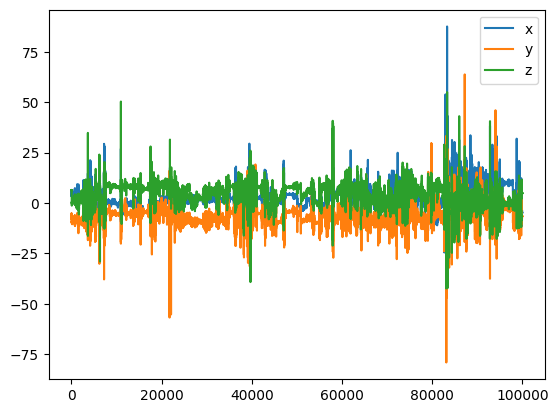

In [7]:
plt.plot(x[:max], label='x')
plt.plot(y[:max], label='y')
plt.plot(z[:max], label='z')
plt.legend()

LETS NOW MAKE SOME DATA TO PASS TO THE NN

In [8]:
def window_maker(data, window_size, stride, flatten):
    """Create windows from time series data."""
    windows = []
    
    if flatten:
        # Flatten x, y, z channels into a single vector per window
        for i in range(0, len(data['x']) - window_size + 1, stride):
            window = []
            window.extend(data['x'][i:i + window_size].tolist())
            window.extend(data['y'][i:i + window_size].tolist())
            window.extend(data['z'][i:i + window_size].tolist())
            windows.append(window)
    else:
        # Keep x, y, z as separate channels
        for i in range(0, len(data['x']) - window_size + 1, stride):
            window = [
                data['x'][i:i + window_size].tolist(),
                data['y'][i:i + window_size].tolist(),
                data['z'][i:i + window_size].tolist()
            ]
            windows.append(window)
            
    return windows


def process_recording(acc_data, gyro_data, window_size, stride, flatten):
    """Extract activity windows and labels from a recording."""

    if len(acc) >= window_size:
        acc_windows_batch = window_maker(acc_data, window_size, stride, flatten)
        gyro_windows_batch = window_maker(gyro_data, window_size, stride, flatten)

        # Handle potential mismatch in window counts
        min_windows = min(len(acc_windows_batch), len(gyro_windows_batch))
        acc_windows_batch = acc_windows_batch[:min_windows]
        gyro_windows_batch = gyro_windows_batch[:min_windows]
    
    return torch.tensor(acc_windows_batch), torch.tensor(gyro_windows_batch)

In [9]:
acc_windows, gyro_windows = process_recording(acc, gyro, window_size=WINDOW_SIZE, stride=STRIDE, flatten=False)
acc_windows.shape, gyro_windows.shape

(torch.Size([28026, 3, 400]), torch.Size([28026, 3, 400]))

In [10]:
all_windows = torch.cat((acc_windows, gyro_windows), dim=1)
all_windows.shape

torch.Size([28026, 6, 400])

now lets define the model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class simple_cnn(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.c0  = nn.Conv1d(6, 64, kernel_size=3, stride=2)

        self.c1  = nn.Conv1d(64, 128, kernel_size=3, stride=2)
        self.c2  = nn.Conv1d(128, 128, kernel_size=3)

        self.c3  = nn.Conv1d(128, 256, kernel_size=3, stride=2)
        self.c4  = nn.Conv1d(256, 256, kernel_size=3)
        self.c5  = nn.Conv1d(256, 256, kernel_size=3)

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.l0 = nn.Linear(256,256)
        self.dropout = nn.Dropout(p=dropout)
        self.out = nn.Linear(256,1)
            
        
    def forward(self, x):
        x = F.relu(self.c0(x), inplace=True)
        
        x = F.relu(self.c1(x), inplace=True)
        x = F.relu(self.c2(x), inplace=True)
        
        x = F.relu(self.c3(x), inplace=True)
        x = F.relu(self.c4(x), inplace=True)
        x = F.relu(self.c5(x), inplace=True)
        
        x = self.gap(x).squeeze(-1)
        x = F.relu(self.l0(x), inplace=True)
        x = self.dropout(x)
        x = self.out(x)
        
        return x


In [12]:
# model = simple_cnn()
# model.load_state_dict(torch.load('/home/kuba/projects/medication-taking-data/new_start/week03/01_augment_loss_weights/92f1_Augmented_loss_weights_simpcnn_09posweight.pth', weights_only=True))
 

from RegNet import RegNet
model = RegNet()
model.load_state_dict(torch.load('/home/kuba/projects/medication-taking-data/new_start/week02/00_no_movment/94f1_with_filter_noMovmets.pth', weights_only=True))

<All keys matched successfully>

In [13]:
device = 'cuda:0'
model = model.to(device)
all_windows = all_windows.to(device)
with torch.no_grad():
    model.eval()
    logits = model(all_windows)

The model was trained to where:
0 = daily life 
1 = medication 

In [14]:
preds = F.sigmoid(logits.cpu())
preds

tensor([[9.9291e-01],
        [8.7640e-01],
        [8.2925e-01],
        ...,
        [1.7090e-13],
        [7.2753e-26],
        [2.3627e-17]])

In [15]:
preds[-10:]

tensor([[1.3781e-12],
        [3.5127e-14],
        [3.1802e-19],
        [6.9928e-15],
        [3.4627e-26],
        [3.8371e-19],
        [1.7364e-34],
        [1.7090e-13],
        [7.2753e-26],
        [2.3627e-17]])

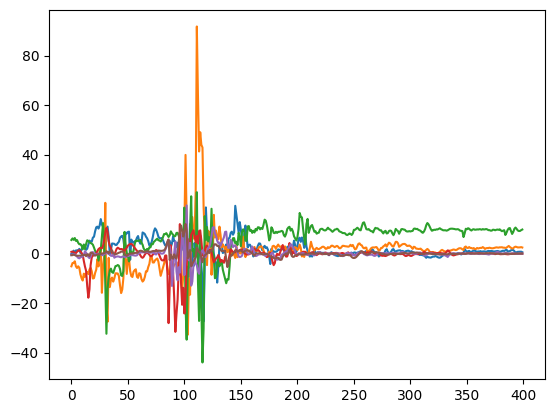

In [16]:
window_num = -1
all_windows = all_windows.cpu()
plt.plot(all_windows[window_num][0])
plt.plot(all_windows[window_num][1])
plt.plot(all_windows[window_num][2])

plt.plot(all_windows[window_num][3])
plt.plot(all_windows[window_num][4])
plt.plot(all_windows[window_num][5])


In [17]:
print(preds[:100])

tensor([[9.9291e-01],
        [8.7640e-01],
        [8.2925e-01],
        [8.3803e-01],
        [8.3487e-01],
        [8.7151e-01],
        [9.5457e-01],
        [9.0434e-01],
        [7.3624e-01],
        [9.6845e-01],
        [2.8287e-01],
        [5.8892e-01],
        [8.1283e-02],
        [9.8472e-01],
        [4.0806e-01],
        [4.7873e-01],
        [8.0512e-01],
        [9.6670e-01],
        [8.5759e-01],
        [9.9290e-01],
        [9.8711e-01],
        [9.7848e-01],
        [9.8171e-01],
        [9.7909e-01],
        [2.1685e-01],
        [9.6312e-01],
        [6.7136e-01],
        [4.5076e-01],
        [1.4256e-04],
        [7.6379e-04],
        [2.8085e-03],
        [1.9255e-05],
        [9.7952e-05],
        [7.2950e-05],
        [6.3554e-03],
        [1.2195e-02],
        [5.1632e-02],
        [2.9984e-01],
        [1.1411e-01],
        [9.2809e-01],
        [4.3268e-01],
        [9.7344e-01],
        [9.6863e-01],
        [6.0875e-01],
        [9.9983e-01],
        [1

In [18]:
preds_list = preds.tolist()
preds_list = [val[0] for val in preds_list]
preds_list.reverse()

In [19]:
len(preds_list)

28026

In [20]:
len(acc)

1401712

In [21]:
counts = np.zeros((len(acc)))
sums = np.zeros((len(acc)))

counts.shape, sums.shape

((1401712,), (1401712,))

In [22]:
len_to_use = min(len(acc) - WINDOW_SIZE, len(gyro) - WINDOW_SIZE) #Handle potential mismatch in window count
for i in range(0, len_to_use, STRIDE):
    val = preds_list.pop()
    sums[i : i+WINDOW_SIZE] += val
    counts[i : i+WINDOW_SIZE] += 1


In [23]:
def smooth_predictions(prediction_sum, counts):
    """
    Smooth predictions by averaging, handling divisions by zero.
    """

    averaged_predictions = prediction_sum / (counts + 0.00001)
    return averaged_predictions


In [24]:
avg_preds = smooth_predictions(sums, counts)

In [25]:
def count_peaks_above_threshold(array, threshold):
    if len(array) < 3:  # Need at least 3 points to have a peak
        return 0
    
    peak_count = 0
    in_peak = False
    
    for i in range(1, len(array)):
        # Start of a potential peak (value rises above threshold)
        if not in_peak and array[i] > threshold and array[i] > array[i-1]:
            in_peak = True
            peak_count += 1
        
        # End of peak (value falls below threshold)
        elif in_peak and array[i] <= threshold:
            in_peak = False
    
    return peak_count

thresh = 0.95
result = count_peaks_above_threshold(avg_preds, thresh)
print(f"Number of peaks above threshold {thresh}: {result}")

Number of peaks above threshold 0.95: 148


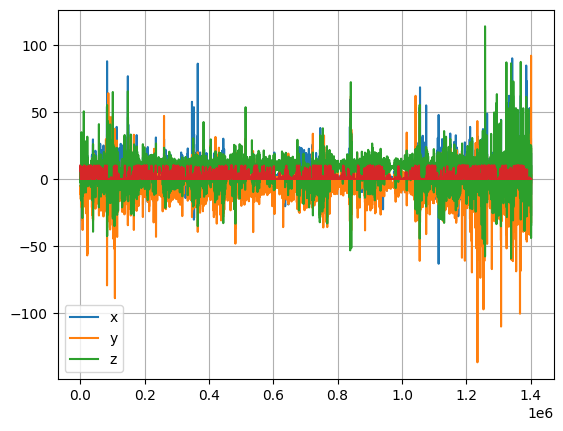

In [26]:
plt.plot(x, label='x')
plt.plot(y, label='y')
plt.plot(z, label='z')
plt.plot((avg_preds * 10))
plt.grid()
plt.legend()

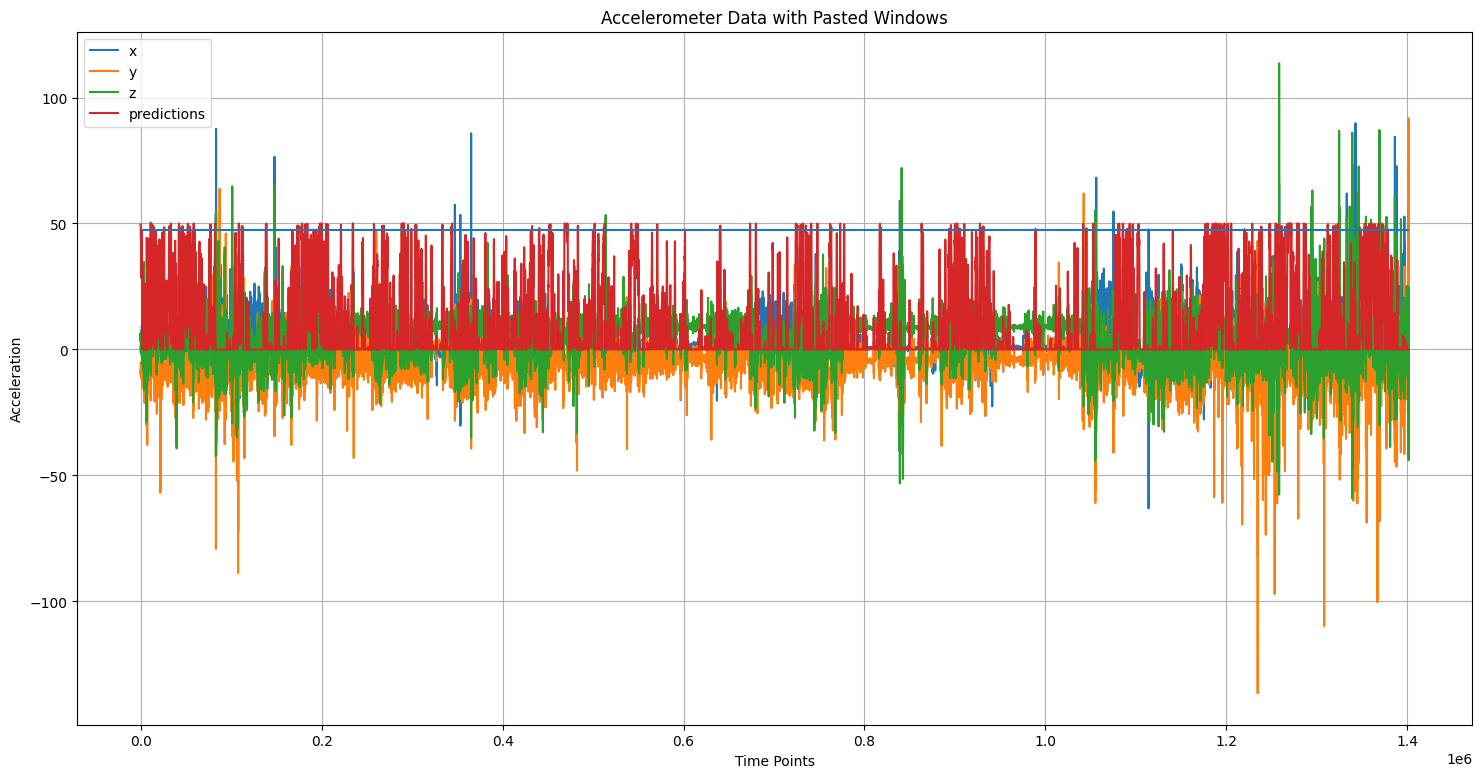

In [27]:


plt.figure(figsize=(18, 9))

# Plot the accelerometer data
plt.plot(x, label='x')
plt.plot(y, label='y')
plt.plot(z, label='z')
plt.plot((avg_preds * 50), label='predictions')
plt.hlines([(0.95 * 50)], xmin=0, xmax=len(x))

plt.grid()
plt.legend()
plt.title('Accelerometer Data with Pasted Windows')
plt.xlabel('Time Points')
plt.ylabel('Acceleration')
plt.show()

In [28]:
def count_medication_taking_predictions(avg_preds, conf_threshold=0.8):
    count = 0
    total_num_windows = 0
    for i in range(0, len(avg_preds) - WINDOW_SIZE, WINDOW_SIZE):
        total_num_windows += 1
        window = avg_preds[i: i + WINDOW_SIZE]
        print(np.mean(window), "  ", i, ":", i+WINDOW_SIZE)
        if np.mean(window) >= conf_threshold :
            count += 1

        
    print(f"There is {count} of {total_num_windows} predictions over the confidance threshold({conf_threshold})")

In [29]:
len(avg_preds[:max]), len(avg_preds)

(100000, 1401712)

In [30]:
count_medication_taking_predictions(avg_preds)

0.9040516989373012    0 : 400
0.7295127328155417    400 : 800
0.7420847206290326    800 : 1200
0.6564446919651382    1200 : 1600
0.09441052951223129    1600 : 2000
0.5145576978873443    2000 : 2400
0.16877928247840562    2400 : 2800
0.22049695975062256    2800 : 3200
0.23767078899557803    3200 : 3600
1.179098121919865e-05    3600 : 4000
7.010496533593501e-06    4000 : 4400
0.13346843113632645    4400 : 4800
0.3742046123891122    4800 : 5200
0.05277126927653303    5200 : 5600
0.3070647504353833    5600 : 6000
0.07889710979894925    6000 : 6400
0.6847145240311728    6400 : 6800
0.40980451588341765    6800 : 7200
0.00018338183483447047    7200 : 7600
0.14746885131473011    7600 : 8000
0.10061422455111518    8000 : 8400
0.5509625539932405    8400 : 8800
0.7028852158345356    8800 : 9200
0.1736559811406886    9200 : 9600
0.29696868612640687    9600 : 10000
0.4911863409421434    10000 : 10400
0.4247323188865569    10400 : 10800
0.09893805374258663    10800 : 11200
0.662073834213392    11200

In [31]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# # Create figure
# fig = go.Figure()

# # Add traces
# fig.add_trace(go.Scatter(x=list(range(len(x[1000000:(1000000 + max)]))), y=x[1000000:(1000000 + max)], mode='lines', name='x'))
# fig.add_trace(go.Scatter(x=list(range(len(y[1000000:(1000000 + max)]))), y=y[1000000:(1000000 + max)], mode='lines', name='y'))
# fig.add_trace(go.Scatter(x=list(range(len(z[1000000:(1000000 + max)]))), y=z[1000000:(1000000 + max)], mode='lines', name='z'))
# fig.add_trace(go.Scatter(x=list(range(len(avg_preds[1000000:(1000000 + max)]))), y=(avg_preds[1000000:(1000000 + max)] * 40), mode='lines', name='avg_preds*40'))

# # Update layout
# fig.update_layout(
#     title='Data Visualization',
#     xaxis_title='Index',
#     yaxis_title='Value',
#     grid=dict(rows=1, columns=1),
#     height=600,  # You can adjust height
#     width=900    # You can adjust width
# )

# # Add grid
# fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
# fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')

# # Display the figure
# fig.show()

In [32]:
def calculate_magnitude(acc, gyro, flatten):
    """Calculate magnitude of acceleration and gyroscope data."""
    if not flatten:
        # Shape: (num_windows, 3, window_size)
        acc_magnitudes = torch.sqrt(acc[:, 0]**2 + acc[:, 1]**2 + acc[:, 2]**2)
        gyro_magnitudes = torch.sqrt(gyro[:, 0]**2 + gyro[:, 1]**2 + gyro[:, 2]**2)
    else:
        # Shape: (num_windows, 3*window_size)
        acc_magnitudes = torch.sqrt(acc**2)
        gyro_magnitudes = torch.sqrt(gyro**2)
        
    return acc_magnitudes, gyro_magnitudes


def filter_static_windows(acc, gyro, flatten=False, acc_threshold=0.05, gyro_threshold=0.02):
    """Remove windows with little or no movement."""
    acc_mag, gyro_mag = calculate_magnitude(acc, gyro, flatten)

    # Calculate standard deviation - low std dev means little variation
    acc_std = torch.std(acc_mag, dim=1)
    gyro_std = torch.std(gyro_mag, dim=1)
    
    # Keep windows with enough movement
    valid_indices = torch.logical_or(acc_std > acc_threshold, gyro_std > gyro_threshold)
    
    filtered_acc = acc[valid_indices]
    filtered_gyro = gyro[valid_indices]
    
    if len(filtered_acc) == 0 or len(filtered_gyro) == 0:
        print("Warning: All windows were filtered out due to lack of movement")
        
    return filtered_acc, filtered_gyro, valid_indices

In [33]:
_, _, valid_idxs = filter_static_windows(acc_windows, gyro_windows)
np.bincount(valid_idxs)

array([  870, 27156])

In [34]:
valid_idxs

tensor([True, True, True,  ..., True, True, True])

In [35]:
invaild_counts = np.zeros((len(acc)))

len_to_use = min(len(acc) - WINDOW_SIZE, len(gyro) - WINDOW_SIZE) #Handle potential mismatch in window count
j = 0
for i in range(0, len_to_use, STRIDE):
    if valid_idxs[j] == False:
        invaild_counts[i : i+WINDOW_SIZE] += 1
    j += 1

invaild_counts = invaild_counts / np.max(invaild_counts)

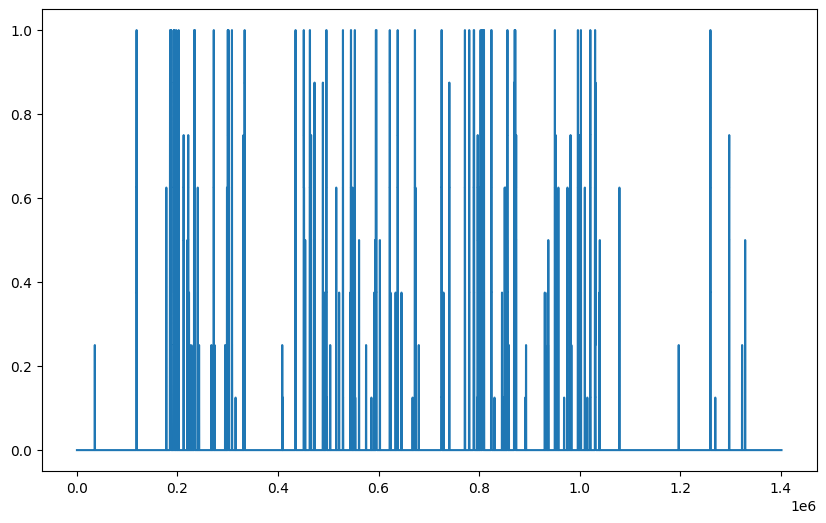

In [36]:
plt.figure(figsize=(10,6))
plt.plot(invaild_counts)

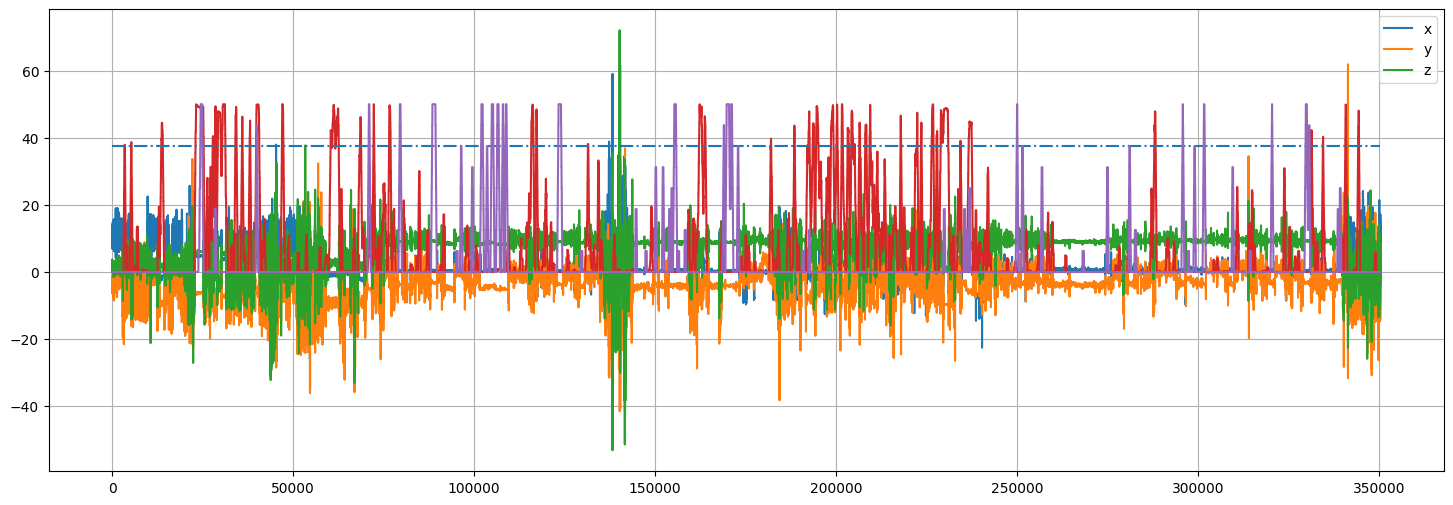

In [37]:
start = int(len(x) * .5)
end  = int(len(x) * .75)

fig, ax = plt.subplots(figsize=(18, 6))

# Then do your plotting
ax.plot(x[start:end], label='x')
ax.plot(y[start:end], label='y')
ax.plot(z[start:end], label='z')
ax.plot((avg_preds[start:end] * 50))
ax.hlines([(0.75 * 50)],xmin=0, xmax=len(x[start:end]), linestyles='dashdot')
plt.plot(invaild_counts[start:end] * 50)
ax.grid()
ax.legend()

# Show or save the figure
plt.show()